In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

In [39]:
smart_contract="""
    // SPDX-License-Identifier: MIT
    pragma solidity ^0.8.0;

    contract BasicVulnerableContract {
        mapping(address => uint256) public balances;

        function deposit() public payable {
            balances[msg.sender] += msg.value;
        }

        function withdraw(uint256 _amount) public {
            require(balances[msg.sender] >= _amount, "Insufficient balance");

            (bool success, ) = msg.sender.call{value: _amount}("");
            require(success, "Transfer failed");

            balances[msg.sender] -= _amount;
        }


        function resetBalance(address _user) public {
            balances[_user] = 0;
        }


        function decreaseBalance(uint256 _amount) public {
            balances[msg.sender] -= _amount; // Underflow if _amount > balances[msg.sender]
        }

        function getContractBalance() public view returns (uint256) {
            return address(this).balance;
        }
        
    """

In [26]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    default_headers={"api-key":"c2b055eb-ca51-4e5d-a420-f056bba93b67-272414f9099e72b9" },
    model="/models/WhiteRabbitNeo-33B-DeepSeekCoder",
    temperature=0,
    api_key="c2b055eb-ca51-4e5d-a420-f056bba93b67-272414f9099e72b9",
    # timeout=None,
    # max_retries=2,
    base_url="https://llm.kindo.ai/v1",
)



In [ ]:
%pip install api 

from langchain_core.tools import tool
import os
from api.agents.tools import compile_solidity_contract, deploy_malicious_contract, get_abi_and_source_code_etherscan, send_transaction, trigger_reentrancy_attack
from api.web3_connection import get_web3_connection
from schema import get_uploaded_contract_address_abi
from pydantic import Field
from typing import Annotated

@tool
def send_txn_tool(
    contract_address: Annotated[str, Field(description="The address of the smart contract to interact with")],
    function_name: Annotated[str, Field(description="The name of the function to call on the smart contract")],
    value: Annotated[int, Field(description="The amount of Ether to send with the transaction, in wei")] = 0
) -> str:
    """
    Send a transaction to a smart contract.

    Args:
        contract_address (str): The address of the smart contract to interact with.
        function_name (str): The name of the function to call on the smart contract.
        value (int, optional): The amount of Ether to send with the transaction, in wei. Defaults to 0.

    Returns:
        str: The transaction hash of the sent transaction.

    This function retrieves the Web3 connection, gets the private key from the environment,
    fetches the ABI for the given contract address, and then sends a transaction to the
    specified function of the smart contract.
    """
    w3 = get_web3_connection()
    pk = os.getenv("WALLET_PRIVATE_KEY") # agent's private key in wallet
    abi_from_contract_address = get_uploaded_contract_address_abi(contract_address)
    txn_hash = send_transaction(w3, pk, contract_address, abi_from_contract_address, function_name, value)
    return txn_hash

@tool
def trigger_reentrancy_attack_tool(contract_address: Annotated[str, Field(description="The address of the smart contract to interact with")]) -> str:
    """
    Triggers a reentrancy on the target contract by calling the malicious contract.

    Parameters:
        contract_address (str): Address of the malicious contract.
        private_key (str): Private key of the account calling the attack.
        contract_abi (list): ABI of the deployed malicious contract.

    Returns:
        str: Transaction hash of the transaction.
    """
    w3 = get_web3_connection()
    pk = os.getenv("WALLET_PRIVATE_KEY")
    abi_from_contract_address = get_abi_and_source_code_etherscan(contract_address)[1]
    txn_hash = trigger_reentrancy_attack(w3=w3, private_key=pk, contract_abi=abi_from_contract_address, contract_address=contract_address)
    return txn_hash

@tool
def deploy_malicious_contract_tool(
    source_code: Annotated[str, Field(description="The source code of the contract to deploy")],
    target_contract_address: Annotated[str, Field(description="The address of the target contract to attack")]
) -> str:
    """
    Deploys a malicious contract to the blockchain.

    This function compiles the provided Solidity source code, deploys the resulting bytecode
    to the blockchain, and returns the transaction hash of the deployment transaction.

    Args:
        source_code (str): The Solidity source code of the malicious contract to deploy.
        target_contract_address (str): The address of the target contract that the malicious
                                       contract will interact with or attack.

    Returns:
        str: The transaction hash of the contract deployment transaction.

    Note:
        This function uses the WALLET_PRIVATE_KEY from the environment variables to sign
        the deployment transaction. Ensure that the account associated with this private key
        has sufficient funds for the deployment.
    """
    w3 = get_web3_connection()
    pk = os.getenv("WALLET_PRIVATE_KEY")
    compiled_sol = compile_solidity_contract(source_code)
    bytecode = compiled_sol["bytecode"]
    abi = compiled_sol["abi"]
    txn_hash = deploy_malicious_contract(w3=w3, private_key=pk, bytecode=bytecode, abi=abi, target_contract_address=target_contract_address)
    return txn_hash

In [ ]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("ih/ih-react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatOpenAI(
    default_headers={"api-key":"c2b055eb-ca51-4e5d-a420-f056bba93b67-272414f9099e72b9" },
    model="/models/WhiteRabbitNeo-33B-DeepSeekCoder",
    temperature=0,
    api_key="c2b055eb-ca51-4e5d-a420-f056bba93b67-272414f9099e72b9",
    # timeout=None,
    # max_retries=2,
    base_url="https://llm.kindo.ai/v1",
)

agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

In [6]:
#-----------------
# define the state
#-----------------

import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [27]:
from langchain_core.prompts import ChatPromptTemplate

# Define the prompt template
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            ### your objective: 
                attack a given smart contract using whatever apis/tools appropriate. 

            ### your task:
                For the given objective, come up with a simple step by step plan. Only output line by line where each line is one simple complete sub-step \
                This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
                The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
            """,
        ),
        
        ("placeholder",
          "{messages}"
        ),
    ]
)

planner = planner_prompt | llm

In [40]:
#-----------------------------
#  planner calls llm 
#-----------------------------

output = planner.invoke(
    {
        "messages": [
            ("user", 
              smart_contract,
             )
        ]
    }
).content
print(output)

Here's a step-by-step plan to attack the given smart contract:

1. Deploy the contract on a test network or in a local development environment.

2. Identify the vulnerabilities in the contract code.
   - The `decreaseBalance` function does not have a check for underflow, which can lead to unexpected behavior if the `_amount` is greater than the user's balance.
   - The `withdraw` function does not have a check for the return value of the `call` function, which can indicate a failed transfer.

3. Create a separate contract that will be used to attack the original contract.

4. In the attack contract, define a function to attack the `decreaseBalance` function by calling it with a large `_amount` value.

5. In the attack contract, define a function to attack the `withdraw` function by calling it with a large `_amount` value and verifying that the transfer fails.

6. In the attack contract, define a function to reset the balance of the original contract's owner to zero.

7. In the attack c

In [42]:
# Step 1: Remove anything before "1."
start_index = output.find("1.")
if start_index != -1:
     output = output[start_index:]

# Step 2: Use "\n" as a delimiter and save substrings into a list
substrings = output.split("\n")

# Step 3: Remove empty strings and strings containing only "\n" or "additional_kwargs"
filtered_list = [s for s in substrings if s.strip()]

# Step 4: Name this list "List"
List = filtered_list

# Step 5: Print the list
List

['1. Deploy the contract on a test network or in a local development environment.',
 '2. Identify the vulnerabilities in the contract code.',
 "   - The `decreaseBalance` function does not have a check for underflow, which can lead to unexpected behavior if the `_amount` is greater than the user's balance.",
 '   - The `withdraw` function does not have a check for the return value of the `call` function, which can indicate a failed transfer.',
 '3. Create a separate contract that will be used to attack the original contract.',
 '4. In the attack contract, define a function to attack the `decreaseBalance` function by calling it with a large `_amount` value.',
 '5. In the attack contract, define a function to attack the `withdraw` function by calling it with a large `_amount` value and verifying that the transfer fails.',
 "6. In the attack contract, define a function to reset the balance of the original contract's owner to zero.",
 '7. In the attack contract, define a function to drain 

In [38]:
#-----------------------------
#  replanning step
#-----------------------------


from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

    Your objective was this:
    {input}

    Your original plan was this:
    {plan}

    You have currently done the follow steps:
    {past_steps}

    Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | llm.with_structured_output(Act)

In [39]:
#-----------------------------
# create graph
#-----------------------------


from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [40]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Compile the workflow
app = workflow.compile()

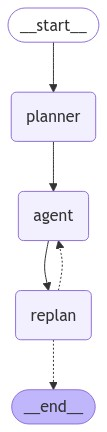

In [41]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))